In [1]:
#dependencies
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'figure.figsize':[12, 8]}) #this is important as it makes the visualizations much easier to read and clip/export!(w,h)

In [2]:
#variables
# we will try multiple epsilon values 
n = 10000
epsillon = [.1,.05,.01]
values = [1,2,3,4,5]

In [3]:
class bandit_class:
    """
    bandit class
    """
    def __init__(self, true_val, value = 0, bayes = 0):        
        #bayes = 0 some greedy
        #bayes 1 = normal form bayes
        #bayes = 2 is alt form
        self.n = 0
        self.value = value #assessed value
        self.tau = 1
        self.bayes = bayes 
        self.true_val = true_val #actual assigned value
        self.sum_x = 0
        self.bambda = 1
        if self.bayes == 2:
            self.tau = 0.0001
            self.value = 1
            self.rewards = []
            
        
    def pull(self):
        return (np.random.random() / np.sqrt(1)) + self.true_val
    
    def update(self, x):
        if self.bayes == 1:
            #found in lazy programmer video
            self.bambda += self.tau
            self.sum_x += x
            self.value = self.tau*self.sum_x / self.bambda
            self.n += 1
                    
        elif self.bayes == 2:
            #alt code found elsewhere to compare
            self.n += 1
            self.sum_x += x
            self.rewards.append(x)
            self.tau += 1 * self.n #1 is the precision which is 1/variance
            self.value = ((self.value * self.tau) + np.mean(self.rewards))/(self.tau + 1)
            
        elif self.bayes == 3:
            #alt code found in lazy programmer git
            self.value = (self.tau * x + self.bambda * self.value) / (self.tau + self.bambda)
            self.bambda += self.tau
            self.n += 1
            
        else:
            self.n += 1
            self.value = (1/self.n * (x - self.value)) + self.value
            
    def value_sample(self):
        if self.bayes:
            return (np.random.random() / np.sqrt(self.bambda)) + self.value
        else:
            return (np.random.random() / np.sqrt(1)) + self.value
      
        

In [4]:
def experiment(n, epsillons, values, plot = 0, annealing_eps = 0, optimistic_starts = 0, exploring_starts = 0):
        
    exploit = 0
    explore = 0
    epsilon_rewards = [[] for i in epsillons]
    greedy_rewards = []
    random_rewards = []
    bayes_rewards1 = []
    bayes_rewards2 = []
    bayes_rewards3 = []
    annealing_rate = 1/(n/10)
    min_eps = 0.0001 #never want to fully stop exploring in case of some weirdness...
    arms = len(epsillons)
    
    
    #eps greedy
    for i in range(len(epsillons)):
        epsillon = epsillons[i] 
        
        if annealing_eps:
            epsillon = max(epsillon - (epsillons[i] * annealing_rate)  ,  min_eps)             
        
        bandits = [bandit_class(i, value = optimistic_starts) for i in values]
        current_reward = 0
        
        #exploring starts, pull each arm how ever many times the variable is set to
        if exploring_starts:
            for selection in range(arms):
                for j in range(exploring_starts):
                    #pull selection
                    reward = bandits[selection].pull()

                    #update selection
                    bandits[selection].update(reward)   

                    #update running reward
                    current_reward += reward
                    epsilon_rewards[i].append(current_reward)
        
        for j in range(n - (exploring_starts*arms)):              
            
            #get max value
            max_arm = np.argmax([k.value_sample() for k in bandits])

            #if explore pick non optimal action
            if np.random.random() < epsillon:
                options = [l for l in range(len(bandits))]
                del options[max_arm]
                selection = np.random.choice(options)
                explore += 1
            else:
                selection = max_arm
                exploit += 1

            #pull selection
            reward = bandits[selection].pull()

            #update selection
            bandits[selection].update(reward)


            #update running reward
            current_reward += reward
            epsilon_rewards[i].append(current_reward)
        
    #ucb 1
    bandits = [bandit_class(i, value = optimistic_starts) for i in values]
    current_reward = 0
    #exploring starts, pull each arm how ever many times the variable is set to
    if exploring_starts:
        for selection in range(arms):
            for j in range(exploring_starts):
                #pull selection
                reward = bandits[selection].pull()

                #update selection
                bandits[selection].update(reward)   

                #update running reward
                current_reward += reward
                greedy_rewards.append(current_reward)

    for j in range(n - (exploring_starts*arms)):
        
        #get max value
        selection = np.argmax([k.value_sample() + (np.sqrt((2* np.log(j + (exploring_starts*arms)))/k.n)) for k in bandits])
            
        #pull selection
        reward = bandits[selection].pull()
        
        #update selection
        bandits[selection].update(reward)        
        
        #update running reward
        current_reward += reward
        greedy_rewards.append(current_reward)
        
    #random
    bandits = [bandit_class(i) for i in values]
    current_reward = 0
    for i in range(n):
        
        #randomly select arm
        options = [j for j in range(len(bandits))]
        selection = np.random.choice(options)
            
        #pull selection
        reward = bandits[selection].pull()
        
        #update selection
        bandits[selection].update(reward)        
        
        #update running reward
        current_reward += reward
        random_rewards.append(current_reward)
        
    #bayesian 1
    bandits = [bandit_class(i, value = optimistic_starts, bayes = 1) for i in values]
    current_reward = 0
              
    for j in range(n):              

        #get max value
        selection = np.argmax([k.value_sample() for k in bandits])

        #pull selection
        reward = bandits[selection].pull()

        #update selection
        bandits[selection].update(reward)

        #update running reward
        current_reward += reward
        bayes_rewards1.append(current_reward)
        
    #bayesian 2
    bandits = [bandit_class(i, value = optimistic_starts, bayes = 2) for i in values]
    current_reward = 0
              
    for j in range(n):              

        #get max value
        selection = np.argmax([k.value_sample() for k in bandits])

        #pull selection
        reward = bandits[selection].pull()

        #update selection
        bandits[selection].update(reward)

        #update running reward
        current_reward += reward
        bayes_rewards2.append(current_reward)

    #bayesian 3
    bandits = [bandit_class(i, value = optimistic_starts, bayes = 3) for i in values]
    current_reward = 0
              
    for j in range(n):              

        #get max value
        selection = np.argmax([k.value_sample() for k in bandits])

        #pull selection
        reward = bandits[selection].pull()

        #update selection
        bandits[selection].update(reward)

        #update running reward
        current_reward += reward
        bayes_rewards3.append(current_reward)
        
    if plot:
        #plot results
        for i in range(len(epsillons)):
            epsillon = epsillons[i]
            plt.plot(epsilon_rewards[i], label = 'epsilon: ' + str(epsillon))
        plt.plot(greedy_rewards, label = 'greedy ucb1')
        plt.plot(random_rewards, label = 'random')
        plt.plot(bayes_rewards1, label = 'bayes 1')  
        plt.plot(bayes_rewards2, label = 'bayes 2') 
        plt.plot(bayes_rewards3, label = 'bayes 3') 
        plt.title('score over experiment run')
        plt.legend()
        plt.show()
    
    return [epsilon_rewards[i][-1] for i in range(len(epsillons))], greedy_rewards[-1], random_rewards[-1], bayes_rewards1[-1], bayes_rewards2[-1], bayes_rewards3[-1]


<ipython-input-4-db6403ccc430>:86: RuntimeWarning: divide by zero encountered in double_scalars
  selection = np.argmax([k.value_sample() + (np.sqrt((2* np.log(j + (exploring_starts*arms)))/k.n)) for k in bandits])


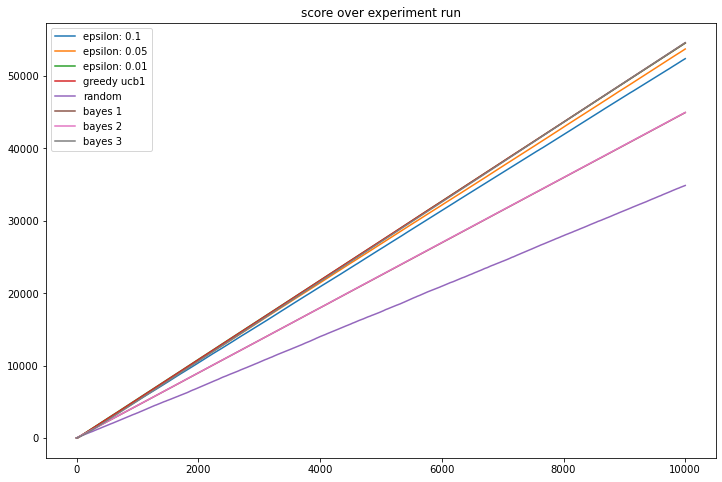

([52393.99592890235, 53731.236249856476, 54537.109665249496],
 54581.3565628352,
 34880.26484974411,
 44946.280288571834,
 44971.41973573523,
 54601.33140228998)

In [5]:
experiment(10000, epsillon, values, plot = 1, annealing_eps = 1, optimistic_starts = 100, exploring_starts = 10)

<ipython-input-4-db6403ccc430>:86: RuntimeWarning: divide by zero encountered in double_scalars
  selection = np.argmax([k.value_sample() + (np.sqrt((2* np.log(j + (exploring_starts*arms)))/k.n)) for k in bandits])


epsilon: 0.1 average rewards: 52407.67110797813
epsilon: 0.05 average rewards: 53665.74537503434
epsilon: 0.01 average rewards: 54648.67082574055
greedy ucb1 average rewards:  54579.76483794661
random average rewards:  34994.42221665418
bayes1 average rewards:  54292.63198688411
bayes2 average rewards:  40090.149208717754
bayes3 average rewards:  54587.21767139311


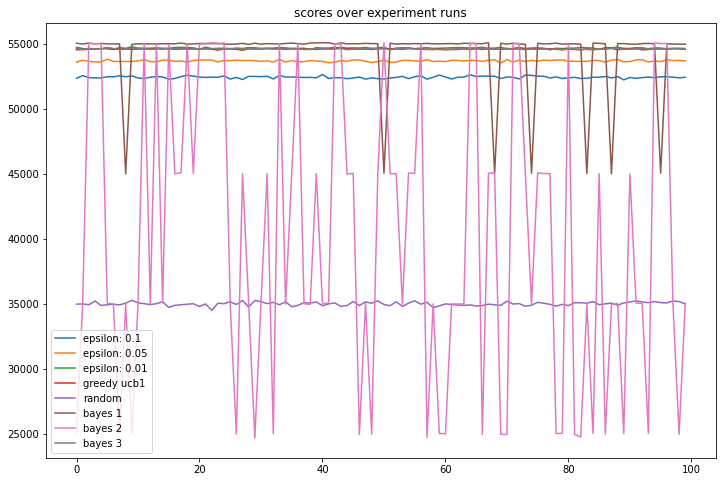

In [6]:
#run experiment 100 times to see how the scores fluctuate with different methods
#annealing epsilon rate
#eps decays over time
#ucb2
#exploring starts will pull each arm before doing value based selection as many times as the value is set to
def multiple_runs(n):
    epsilon_rewards = [[] for i in epsillon]
    greedy_rewards = []
    random_rewards = []
    bayesian_rewards1 = []
    bayesian_rewards2 = []
    bayesian_rewards3 = []
    for i in range(n):
        eps, greed, rand, bayes1, bayes2, bayes3 = experiment(10000, epsillon, values, plot = 0, annealing_eps = 1, optimistic_starts = 100, exploring_starts = 10) 
        
        for j in range(len(epsillon)):
            epsilon_rewards[j].append(eps[j])
        greedy_rewards.append(greed)
        random_rewards.append(rand)
        bayesian_rewards1.append(bayes1)
        bayesian_rewards2.append(bayes2)
        bayesian_rewards3.append(bayes3)
    
    #plot results
    for k in range(len(epsillon)):
        epsi = epsillon[k]
        plt.plot(epsilon_rewards[k], label = 'epsilon: ' + str(epsi))
        print('epsilon: ' + str(epsi) + ' average rewards: ' + str(np.mean(epsilon_rewards[k])))
    plt.plot(greedy_rewards, label = 'greedy ucb1')
    print('greedy ucb1 average rewards: ', np.mean(greedy_rewards))
    plt.plot(random_rewards, label = 'random') 
    print('random average rewards: ', np.mean(random_rewards))
    plt.plot(bayesian_rewards1, label = 'bayes 1')
    print('bayes1 average rewards: ', np.mean(bayesian_rewards1))
    plt.plot(bayesian_rewards2, label = 'bayes 2') 
    print('bayes2 average rewards: ', np.mean(bayesian_rewards2))
    plt.plot(bayesian_rewards3, label = 'bayes 3')
    print('bayes3 average rewards: ', np.mean(bayesian_rewards3))
    plt.title('scores over experiment runs')
    plt.legend()
    plt.show()   
    
    print()
    
multiple_runs(100)

different combinations of controls and algorithms produce different results.